**Objectif** : on va dans un premier temps chercher à prédire la consommation électrique de la métropole parisienne uniquement à partir des données historiques. Pour cela on va :
- importer et nettoyer les données de consommation électrique
- explorer les données (statistiques descriptives, visualisations graphiques)
- déterminer quel modèle va nous permettre d'effectuer une prédiction
- tronquer la fin de la série, estimer le modèle, effectuer une prédiction puis vérifier la qualité de la prédiction avec les données réelles

Dans un deuxième temps on va utiliser les données météorologiques afin d'améliorer la prédiction.

# 1 - Import des bibliothèques

## 1.1 - Packages python

In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1.2 - Fonctions créées

In [3]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)

from fonctions_conso import *

# 2 - Import des données de consommation électrique

On utilise les données de consommation électrique de la métropole du Grand Paris. On dispose des données du 1er janvier 2020 à aujourd'hui.

In [4]:
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"

In [5]:
df_paris = importation(url)

C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\scripts\fonctions_conso.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url, sep=';')


# 3 - Exploration initiale

In [6]:
df_paris.head(1)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,200054781,Métropole du Grand Paris,Données temps réel,2020-09-01,20:15,2020-09-01T20:15:00+02:00,3819.0,NaN,NaN


In [7]:
df_paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210236 entries, 0 to 210235
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Code métropole      210236 non-null  int64  
 1   Métropole           210236 non-null  object 
 2   Nature              210236 non-null  object 
 3   Date                210236 non-null  object 
 4   Heures              210236 non-null  object 
 5   Date - Heure        210236 non-null  object 
 6   Consommation (MW)   208979 non-null  float64
 7   Production          131306 non-null  object 
 8   Echanges physiques  131306 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 14.4+ MB


In [8]:
nan = df_paris.loc[df_paris['Consommation (MW)'].isna()].shape[0]
zeros = df_paris.loc[df_paris['Consommation (MW)'] == 0].shape[0]

print('La colonne consommation du df comporte ' + str(nan) + ' valeurs manquantes et ' + str(zeros) + 
      ' valeurs nulles.')

La colonne consommation du df comporte 1257 valeurs manquantes et 140 valeurs nulles.


On remarque que :

- les dates sont en format str et non date
- le df n'est pas trié par date
- on a des valeurs manquantes et également des consommations égales à 0
- certaines colonnes ne vont pas nous être utiles

# 4 - Nettoyage des données

## 4.1 - Nettoyage structurel

On renomme les colonnes, convertit en format date, trie par date.

**Attention** : on ne fait pas `pd.to_datetime(df['Date - Heure'])` directement car Python va normaliser le fuseau horaire spécifié et on n'aura plus l'heure locale mais l'heure par rapport au fuseau horaire 0, ce qui peut fausser l'heure de 2 heures par rapport à l'heure locale.

In [9]:
df_paris_clean = clean(df_paris)

In [10]:
df_paris_clean.tail(2)

,code_met,met,date,heure,conso
date_heure,,,,,
2025-12-28 23:30:00,200054781,Métropole du Grand Paris,2025-12-28,23:30,5356.0
2025-12-28 23:45:00,200054781,Métropole du Grand Paris,2025-12-28,23:45,5299.0


In [11]:
df_paris_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210140 entries, 2020-01-01 01:00:00 to 2025-12-28 23:45:00
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   code_met  210140 non-null  int64         
 1   met       210140 non-null  object        
 2   date      210140 non-null  datetime64[ns]
 3   heure     210140 non-null  object        
 4   conso     208765 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 9.6+ MB


On remarque que toutes les colonnes sont remplies exceptée la colonne conso qui contient ~1300 valeurs manquantes qu'on va devoir traiter.

## 4.2 - Traitement des valeurs manquantes

En explorant les données manquantes on en remarque plusieurs types :
- les données manquantes "individuelles" : une seule donnée manque
- les données manquantes par plage : toute une période est manquante
  
On va estimer par interpolation des données manquantes individuelles ou les petites plages de données (16 données au maximum correspondant à 4h de données manquantes). Pour les plages plus importantes (la plus longue étant 90 correspondant à 22h30 de données manquantes), on va essayer de se baser sur les informations historiques.

### 4.2.1 - Reconstruire les valeurs manquantes

In [12]:
df_paris_final = traitement_valeurs_manquantes(df_paris_clean)

### 4.2.2 - Vérification

In [13]:
interp = df_paris_final.loc[(df_paris_final['conso'].isna()) & (~df_paris_final['conso_interp'].isna())].shape[0]
j7 = df_paris_final.loc[(df_paris_final['conso'].isna()) & (df_paris_final['conso_interp'].isna())].shape[0]

print('Sur les ' + str(interp+j7) + ' valeurs manquantes, ' + str(interp) + 
      ' sont associées à de petites plages et ont pu être remplies par interpolation tandis que ' + str(j7) +
      ' données ont du être reconstruites en associant la valeur J-7.')

Sur les 1375 valeurs manquantes, 628 sont associées à de petites plages et ont pu être remplies par interpolation tandis que 747 données ont du être reconstruites en associant la valeur J-7.


In [14]:
df_paris_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210140 entries, 2020-01-01 01:00:00 to 2025-12-28 23:45:00
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   code_met      210140 non-null  int64         
 1   met           210140 non-null  object        
 2   date          210140 non-null  datetime64[ns]
 3   heure         210140 non-null  object        
 4   conso         208765 non-null  float64       
 5   conso_interp  209393 non-null  float64       
 6   conso_final   210140 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 12.8+ MB


La colonne `conso_final` ne contient plus aucun NaN, comme prévu.

### 4.2.3 - Vérification graphique de la cohérence des valeurs imputées

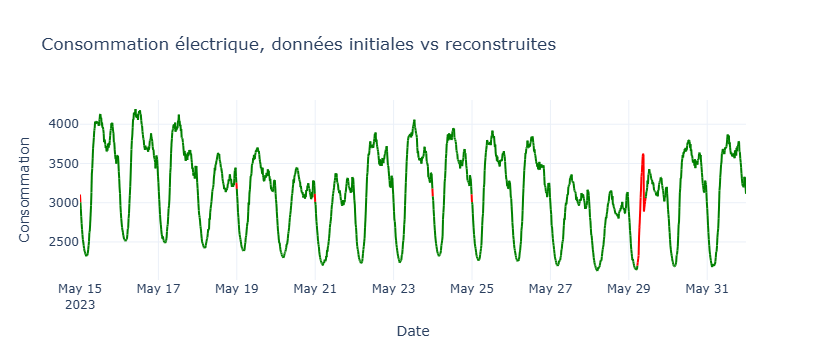

In [16]:
start = "2023-05-15"
end   = "2023-05-31"

graph_valeurs_manquantes (start, end, df_paris_final)

In [17]:
df_paris_final.loc[start:end][1364:1386]

,code_met,met,date,heure,conso,conso_interp,conso_final
date_heure,,,,,,,
2023-05-29 05:00:00,200054781,Métropole du Grand Paris,2023-05-29,05:00,2154.0,2154.000000,2154.000000
2023-05-29 05:15:00,200054781,Métropole du Grand Paris,2023-05-29,05:15,NaN,2197.190476,2197.190476
2023-05-29 05:30:00,200054781,Métropole du Grand Paris,2023-05-29,05:30,NaN,2240.380952,2240.380952
2023-05-29 05:45:00,200054781,Métropole du Grand Paris,2023-05-29,05:45,NaN,2283.571429,2283.571429
2023-05-29 06:00:00,200054781,Métropole du Grand Paris,2023-05-29,06:00,NaN,2326.761905,2326.761905
2023-05-29 06:15:00,200054781,Métropole du Grand Paris,2023-05-29,06:15,NaN,NaN,2550.000000
2023-05-29 06:30:00,200054781,Métropole du Grand Paris,2023-05-29,06:30,NaN,NaN,2680.000000
2023-05-29 06:45:00,200054781,Métropole du Grand Paris,2023-05-29,06:45,NaN,NaN,2780.000000
2023-05-29 07:00:00,200054781,Métropole du Grand Paris,2023-05-29,07:00,NaN,NaN,2907.000000


Les données interpolées paraissent cohérentes. Les données reconstruites via j-7 sont moins fiables : par exemple le pic reconstruit pour le 29 mai 2023 parait peu crédible.

# 5 - Statistiques descriptives

On va calculer la moyenne, médiane, mode (conso la + fréquente), min, max, amplitude, écart-type, variance, skewness et kurtosis.

In [18]:
display(stats_desc(df_paris_final))

,Moyenne,Médiane,Mode,Min,Max,Amplitude,Écart-type,Variance,Skewness,Kurtosis
Valeur,3974.75,3847.0,3845.0,1974.0,7795.0,5821.0,1050.74,1104060.89,0.53,-0.18


**Interprétation** :

- moyenne = 3973 > médiane = 3846 : distribution plutôt asymétrique avec une queue à droite, présence de valeurs extrêmes tirant la moyenne vers le haut
- amplitude et écart-type élevés indiquent une grande dispersion des données autour de la moyenne
- skewness = 0.53 : la distribution est légèrement étendue à droite, cpnfirmant la présence de grandes valeurs extrêmes
- kurtosis = 0.18 : la distribution est un peu plus plate qu'une distribution normale, la quantité de valeurs extrêmes demeure raisonnable
  
**Conclusion** : sans doute présence de valeurs extrêmes dans des proportions limitées

# 6 - Visualisations

On peut déjà commencer par représenter notre série telle quelle :

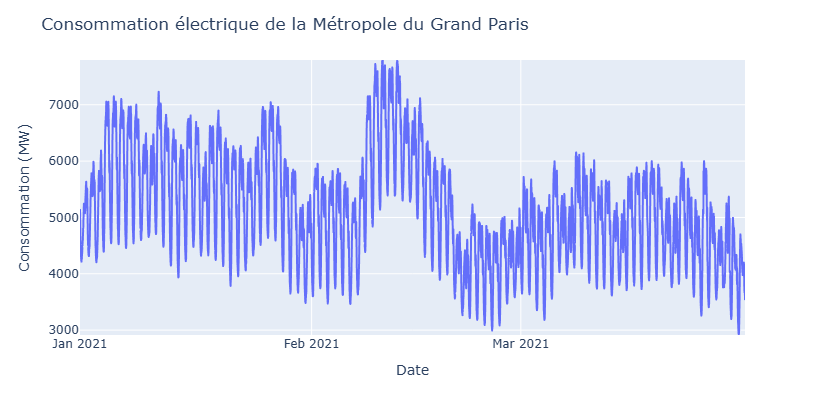

In [19]:
#spécifier date de début et de fin pour le graphe

start = '2021-01-01'
end = '2021-03-31'

graph(start, end, df_paris_final)

On va ensuite affiner nos visualisations afin de détecter déjà certaines choses dans nos données :
- mettre en lumière la tendance générale
- calculer la consommation totale par année et par mois
- représenter l'ampleur de la consommation selon le jour et l'heure par une heatmap
- détecter d'eventuels profils journaliers : semaine vs week-end, jours d'été vs jours d'hiver

Pour cela on va devoir adapter légèrement le dataframe : ajouter le jour de la semaine, la saison, est-ce qu'il s'agit du week-end ou non...

In [20]:
#adaptation du df aux besoins de visualisation
df_vis = df_visual (df_paris_final)

In [21]:
df_vis.head(2)

,conso_final,heure_quart,heure,jour_semaine,is_weekend,mois,saison
date_heure,,,,,,,
2020-01-01 01:00:00,5090.0,1.00,1,Wednesday,False,1,hiver
2020-01-01 01:15:00,5018.0,1.25,1,Wednesday,False,1,hiver


## 6.1 - Tendance de fond

On va mettre en lumière la tendance de fond en calculant des **moyennes glissantes** pour nos données. On rappelle qu'une moyenne glissante sur *n* périodes prend à chaque instant la moyenne des *n* dernières valeurs. L'objectif est de lisser les données pour obtenir une courbe qui se rapproche plutôt d'une tendance globale. Le point clé va être de définir le nombre de périodes *n* sur lequel est calculée la moyenne glissante. Au plus n est grand, au plus la courbe est lissée et au plus n est petit au plus elle est proche des données brutes.

Ici *n* correspond à un nombre de jours.

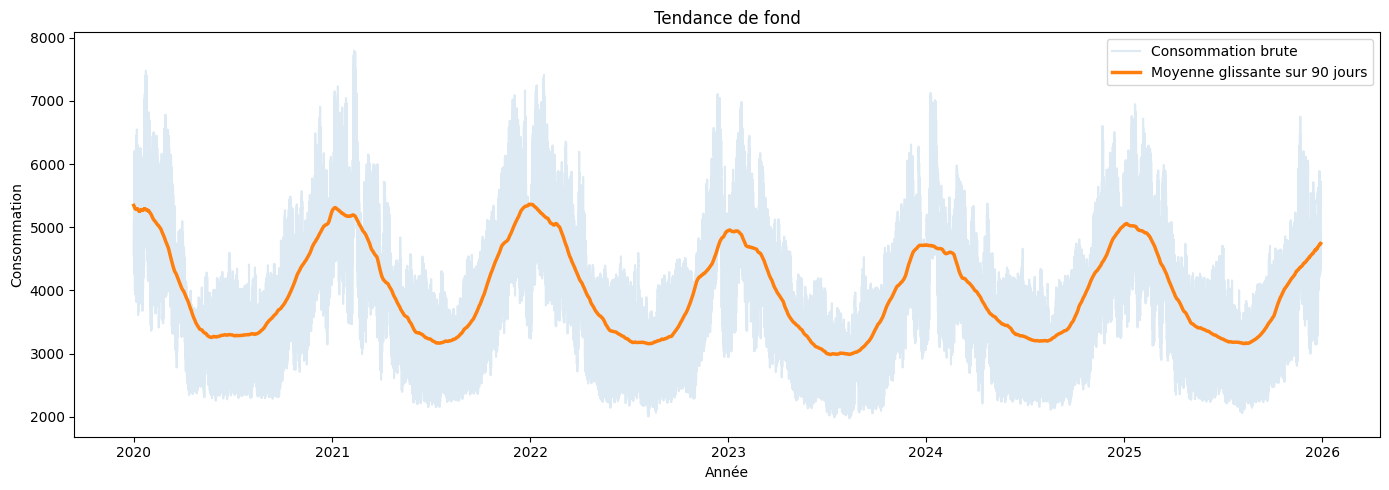

In [22]:
tendance(df_vis,90) #le deuxième argument est n le nombre de périodes sur lequel est calculé la moyenne glissante

**Interprétation** : on remarque une saisonnalité très forte avec une forte baisse de la consommation en milieu d'année (été) comparativement au début et à la fin de l'année (hiver).

## 6.2 - Consomlmation totale par mois et par année

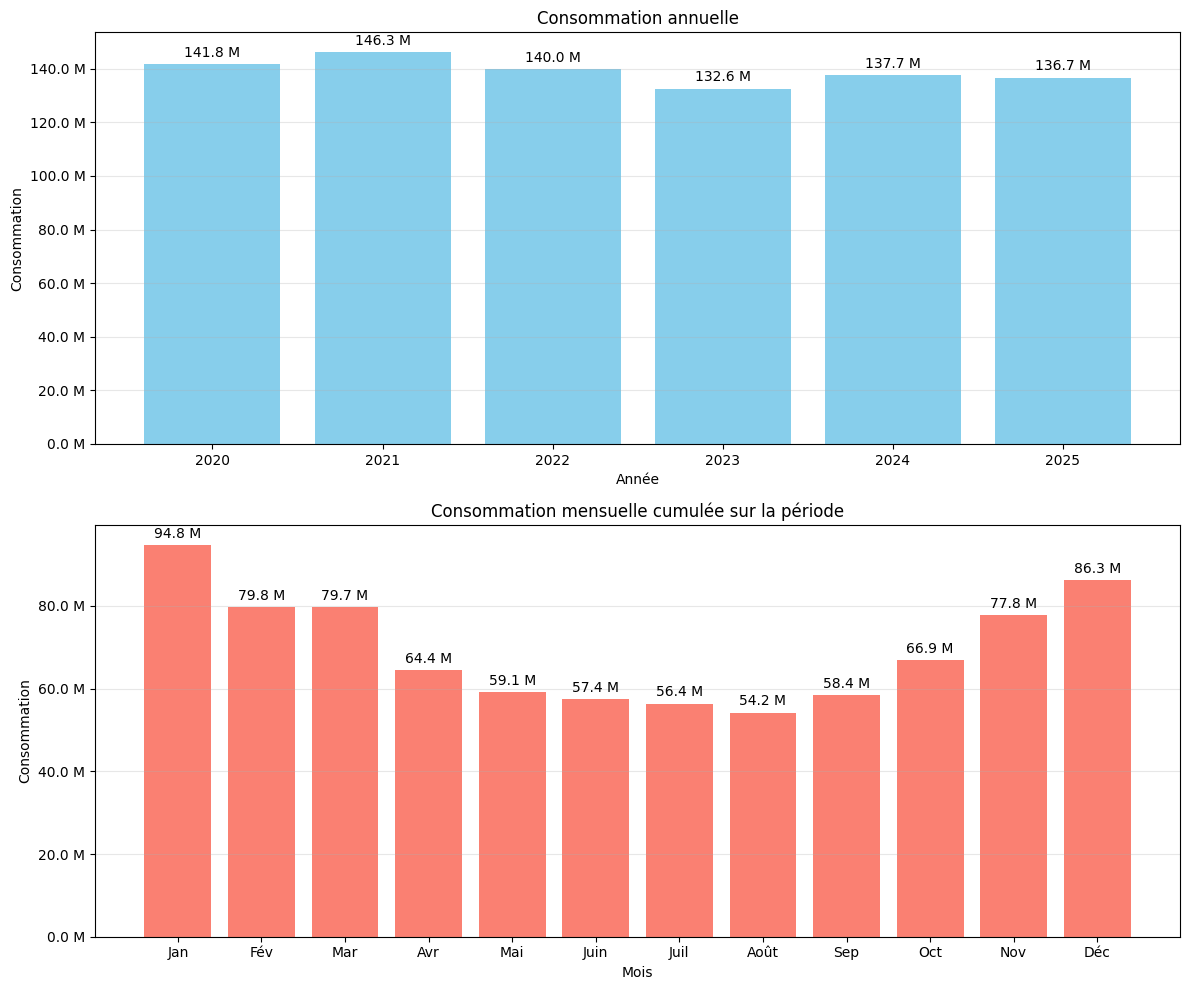

In [23]:
conso_tot(df_vis)

**Interprétation**: la saisonnalité déjà évoquée se retrouve dans l'histogramme avec une consommation beaucoup plus faible en juillet et août notamment. Quant à la somme de la consommation par année elle est plutôt stable voire légèrement en baisse.

## 6.3 - Heatmap jour x heure

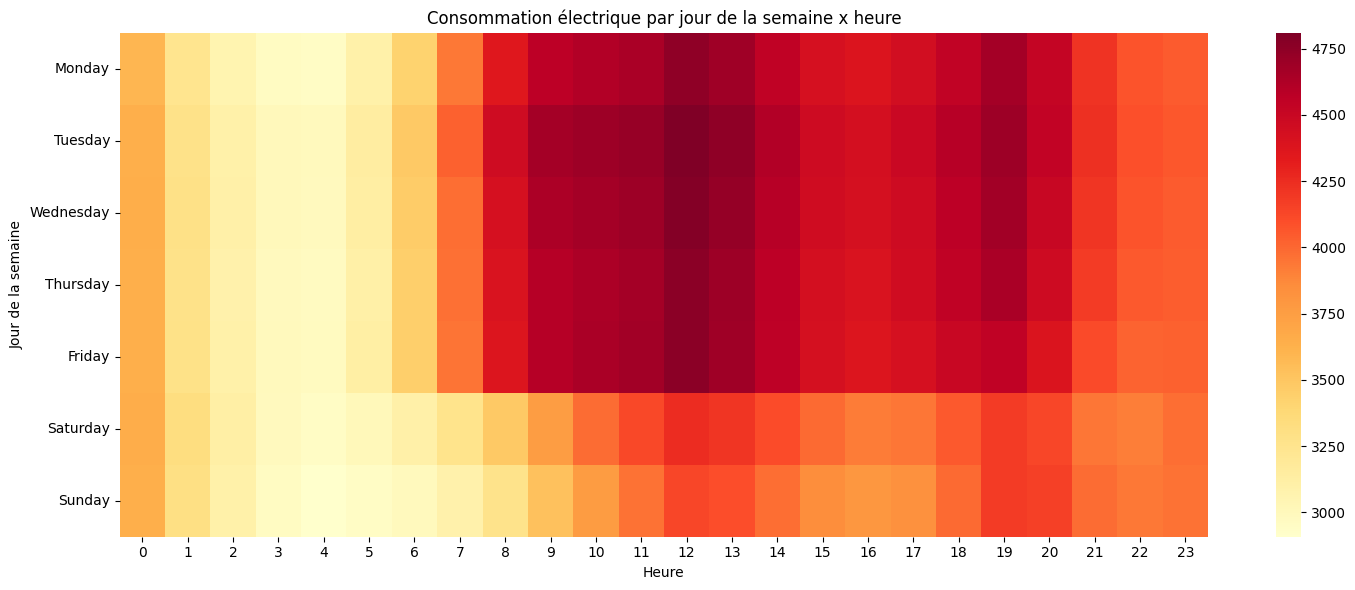

In [24]:
heatmap(df_vis)

**Interprétation** : la consommation est sensiblement plus faible entre 1h et 6h du matin quelque soit le jour de la semaine. Le week-end, le début de la hausse de la consommation se fait plus tardivement, aux alentous de 9-10h contre 6-7h en semaine. En semaine on constate un pic de consommation vers 12h puis vers 19h tandis que le week end la consommation est plutôt stable quelque soit l'heure.

## 6.5 - Profils journaliers

### 6.5.1 - Semaine vs week end

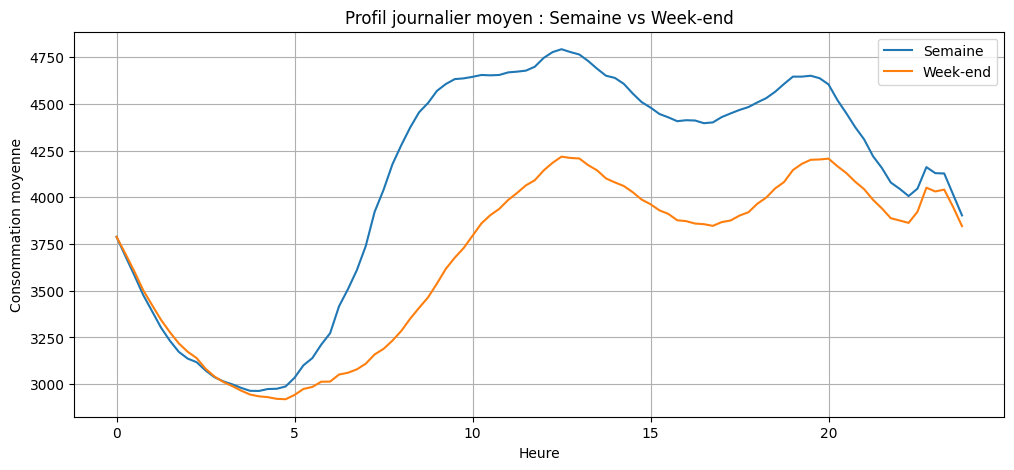

In [25]:
profil_semaine_we(df_vis)

**Interprétation** : on a très clairement un profil de consommation différent entre les jours de la semaine et ceux du week end. L'allure de la courbe est sensiblement similaire mais c'est le niveau qui est beaucoup plus élevé pour les jours de semaine. Regardons plus précisément ce qu'il en est jour par jour.

### 6.5.3 - Par jour de la semaine

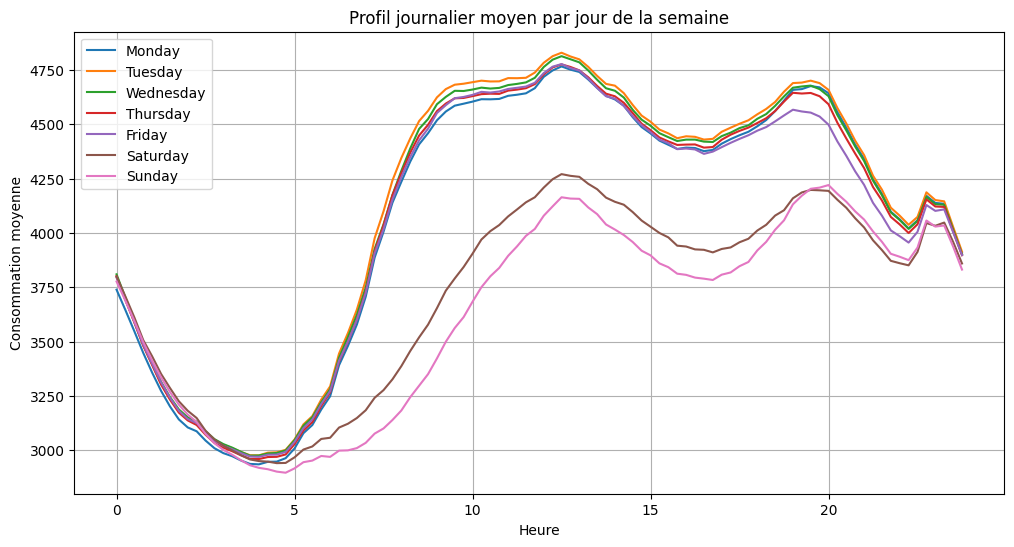

In [26]:
profil_jour_semaine(df_vis)

**Interprétation** : les 5 jours de semaine se confondent quasiment parfaitement. Seul le vendredi après-midi semble être légèrement différent avec une consommation plus faible. Le profil entre le samedi et le dimanche n'est pas exactement le même, la consommation étant globalement plus faible le dimanche quoiqu'elle semble remonter en fin de journée.

### 6.5.2 - Été vs hiver

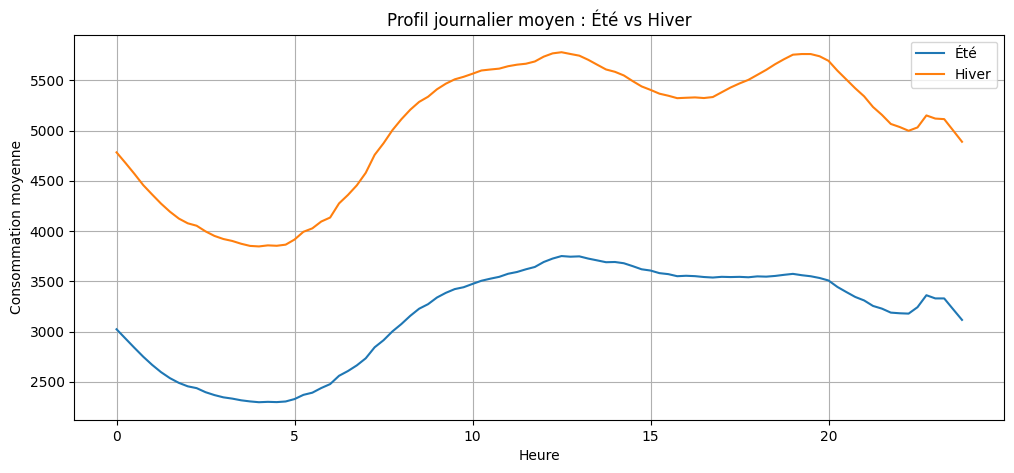

In [27]:
profil_ete_hiver(df_vis)

**Interprétation** : il y a clairement un écart de niveau entre la consommation en été et en hiver.

## 6.6 - Conclusion

Les visualisations effectuées ont permis de détecter de nombreuses saisonnalités dans les données : journalières, hebdomadaires et mensuelles notamment. On va devoir en tenir compte lors de l'estimation du modèle de prédiction. Cette estimation va passer par les étapes suivantes :
- vérification de la stationnarité de la série
- dé-saisonnaliser et détrender la série
- déterminer un modèle permettant d'estimer les résidus ainsi obtenus
- séparer en train et test les données, entrainer le modèle sur le train puis prédire le test
- vérifier la qualité de la prédiction

# 7 - Test de stationnarité

Tester la stationnarité d'une série temporelle est crucial pour l'analyse et la modélisation des données temporelles. La stationnarité garantit la stabilité des propriétés statistiques de la série au fil du temps, permettant d'appliquer des modèles appropriés et d'obtenir des résultats valides et des prévisions fiables.

On rappelle qu'une série temporelle à valeurs réelles en temps discret $X_1,...,X_t$ est dite faiblement stationnaire si :

$$
\begin{cases}
\mathbb{E}[X_i] = \mu \hspace{1cm} \forall i \\
Var(X_i) = \sigma ^2 \hspace{1cm} \forall i \\
Cov(X_i, X_{i-k}) = \rho _k \hspace{1cm} \forall i, \forall k
\end{cases}
$$

On va commencer par tester la stationnarité de la série des consommations d'électricité de la métropole parisienne afin de choisir par la suite le bon modèle de prédiction. Pour cela, on effectue le test de racine unitaire de Dickey-Füller augmenté (test ADF) dont les hypothèses sont les suivantes :

$$
\begin{cases}
H_0 : \text{présence de racine unitaire} \Leftrightarrow \text{série non stationnaire} \\
H_1 : \text{absence de racine unitaire} \Leftrightarrow \text{série stationnaire}
\end{cases}
$$

Les valeurs critiques du test ADF diffèrent selon l'hypothèse choisie pour le processus générateur de données (DGP) de la série temporelle :

- **DGP 1** (sans partie déterministe, option `regression='n'` dans adfuller) : 
$ X_t = \phi X_{t-1} + \epsilon_t $

Valeur critique au seuil 5% pour le rejet de $H_0$ : -1,95

- **DGP 2** (avec constante, option `regression='c'` dans adfuller) :  
$ X_t = a + \phi X_{t-1} + \epsilon_t $ 

Valeur critique au seuil 5% pour le rejet de $H_0$ : -2,89

- **DGP 3** (avec constante et trend, option `regression='ct'` dans adfuller) : 
$X_t = a + b t + \phi X_{t-1} + \epsilon_t $ 

Valeur critique au seuil 5% pour le rejet de $H_0$ : -3,45

Lorsque la valeur du test ADF est inférieure au seuil critique associé à l'hypothèse choisie, on rejette $H_0$, c’est-à-dire que la série est stationnaire.


In [29]:
adf_table(df_paris_final[['conso_final']])

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-1.229916,-1.941001,Non stationnaire
1,DGP2,-5.723760,-2.861554,Stationnaire
2,DGP3,-5.717104,-3.410511,Stationnaire


**Conclusion** : la série est stationnaire autour d'une constante $\neq$ 0. Elle est de type DGP3 avec a et b significatifs. On n'a donc pas besoin de la stationnariser et il va être plus facile d'effectuer des prédictions.

# 8 - Dé-saisonnaliser la série

Il existe plusieurs modèles classiques pour la modélisation des séries temporelles :
- <u>AR</u> (AutoRegressive) : la valeur actuelle dépend de ses valeurs passées, utilisé lorsque la série présente de l'autocorrélation
- <u>MA</u> (MovingAverage) : la valeur actuelle dépend des erreurs passées, utilisé lorsque les chocs passés influencent les valeurs futures
- <u>ARMA</u> : AR + MA utilisé lorsque les séries sont stationnaires
- <u>ARIMA</u> : extension d'ARMA aux séries non stationnaires basé sur un nombre de différenciations qui rend la série stationnaire
- <u>SARIMA</u> : ARIMA + saisonnalité
- <u>GARCH</u> : modélise la volatilité passée combinée à l'effet des chocs passés

Chaque modèle dépend d'un ou plusieurs paramètres appelés *ordre* à déterminer à partir des valeurs de la série.

La série étant stationnaire, on va vraisemblablement l'estimer par un modèle **ARMA**. Mais la série des consommations électriques présente de fortes saisonnalités journalière, hebdomadaire et mensuelle ce qui risque de biaiser fortement les coefficients de l'ARMA. Pour cela on va devoir au préalable **désaisonnaliser** la série. On ne va pas pouvoir utiliser un modèle SARIMA car le modèle SARIMA ne peut gérer qu'une seule saisonnalité.

## 8.1 - STL

On va utiliser **STL** (Seasonal–Trend decomposition using LOESS) pour gérer la saisonnalité. Cette méthode va permettre d'isoler les saisonnalités (jour, semaine, mois),  de comprendre la structure de la série et donc de la rendre exploitable pour des modèles comme ARMA. Pour cela, STL décompose la série temporelle en 3 parties :
$$ X_t = T_t + S_t + \epsilon _t$$
où : 
- $X_t$ est la série temporelle observée 
- $T_t$ correspond à la tendance de la série, elle capture la composante à long terme montrant la direction générale de la série. 
- $S_t$ est la composante saisonnière, elle représente les variations régulières et périodiques liées à des motifs récurrents. On va ici considérer 3 saisonnalités : jour, semaine et mois donc cette composante est elle même composée de 3 composantes disctinctes.
- $\epsilon _t$ est la composante résiduelle, on a $\epsilon _t = C_t + u_t$ avec $C_t$ la composante cyclique qui capture des variations à plus long terme que la composante saisonnière mais sans une périodicité fixe et $u_t$ un bruit blanc purement aléatoire. La décomposition de la composante résiduelle entre $C_t$ et $u_t$ se fera en appliquant un ARMA à la décomposition STL.

**Pb** : on a un échantillon beaucoup trop gros, le code prendrait beaucoup trop de temps à s'exécuter. On va être obligés de réduire la fréquence des observations à 1 heure au lieu de 15 minutes. Ainsi, la décomposition journalière et hebdomaire se font assez rapidement, la décomposoition mensuelle prend quant à elle $\approx$ 20 minutes.

In [34]:
df_red = df_paris_final[(df_paris_final.index.minute == 0) & (df_paris_final.index.second == 0)][['conso_final']]
df_red.shape[0]

52535

Le dataframe ainsi réduit ne comporte plus que $\approx$ 50 00 observations contre plus de 210 000 pour le dataframe initial.

In [36]:
#extraire la saison journalière (24 mesures par jour)

stl_daily = STL(df_red, period=24, robust=True)
res_daily = stl_daily.fit()
deseason_daily = df_red['conso_final'] - res_daily.seasonal

In [37]:
#extraire la saison hebdomadaire sur les résidus (24*7=168 mesures)
# ~5min

stl_weekly = STL(deseason_daily, period=168, robust=True)
res_weekly = stl_weekly.fit()
deseason_weekly = deseason_daily - res_weekly.seasonal

In [38]:
#extraire la saison mensuelle sur les résidus (24*30=720 mesures)
# ~20min

stl_monthly = STL(deseason_weekly, period=720, robust=True)
res_monthly = stl_monthly.fit()
residuals = deseason_weekly - res_monthly.seasonal

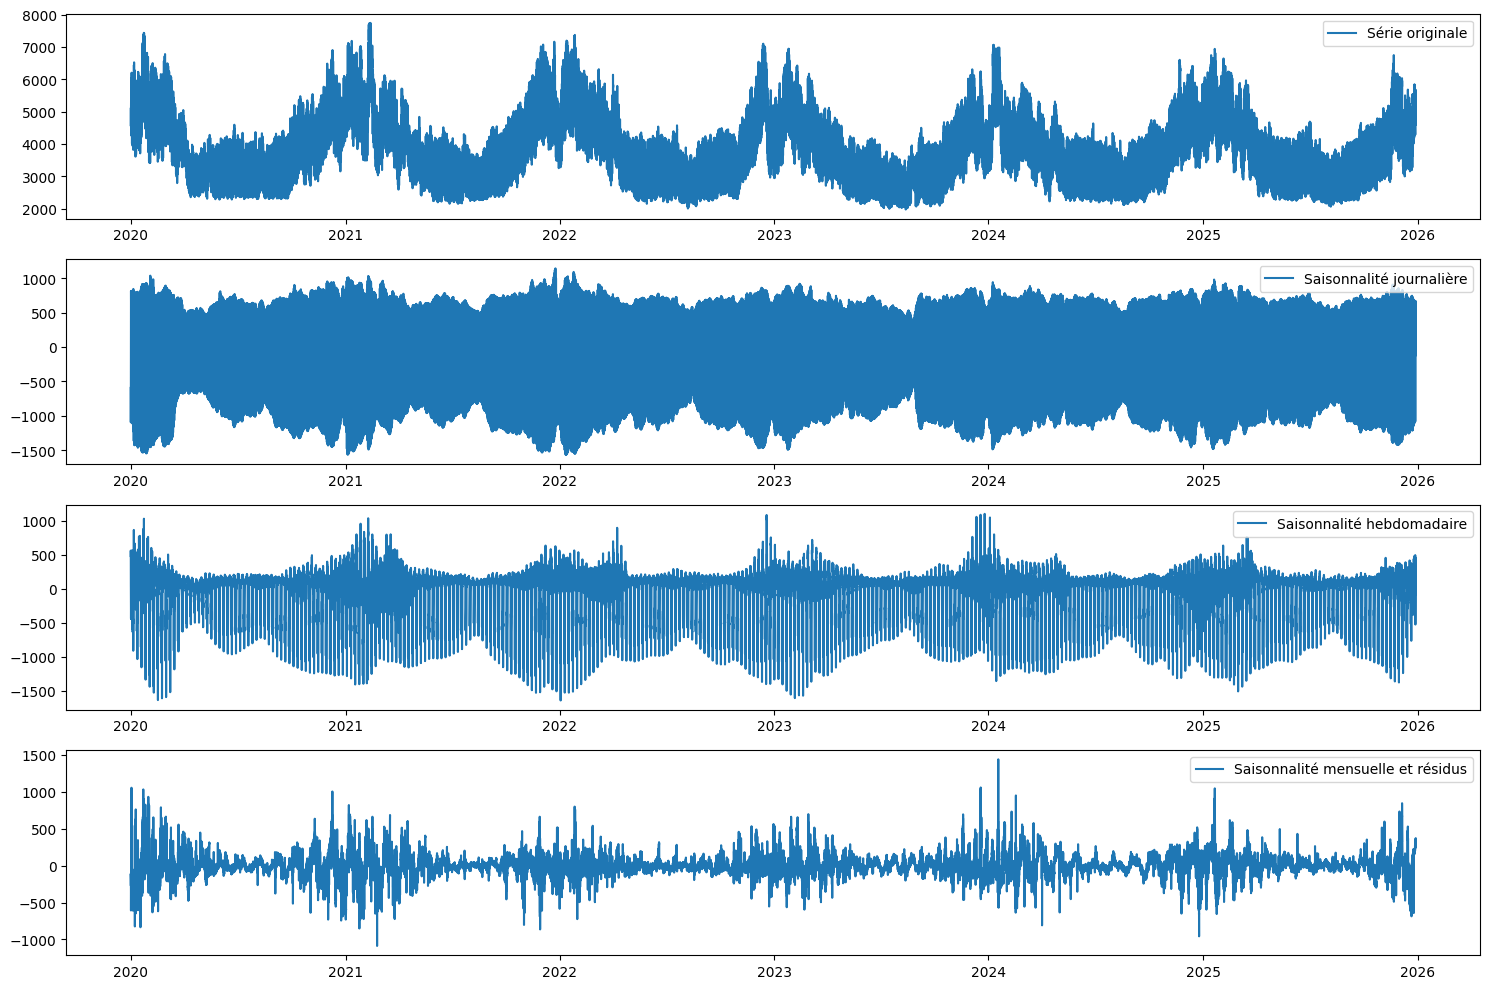

In [39]:
#visualiser

plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(df_red, label='Série originale')
plt.legend()

plt.subplot(4,1,2)
plt.plot(res_daily.seasonal, label='Saisonnalité journalière')
plt.legend()

plt.subplot(4,1,3)
plt.plot(res_weekly.seasonal, label='Saisonnalité hebdomadaire')
plt.legend()

plt.subplot(4,1,4)
plt.plot(res_monthly.seasonal, label='Saisonnalité mensuelle et résidus')
plt.legend()

plt.tight_layout()
plt.show()

**Interprétation** : 
- graphe 2 : saisonnalité journalière très marquée, répétition quasi parfaite du même motif sur toute la période, il s'agit du cycle jour-nuit qui décrit des comportements de consommation très réguliers
- graphe 3 : saisonnalité hebdomadaire d'une amplitude moins importante que celle du cycle jour-nuit et qui varie selon la période, été ou hiver
- graph 4  : mélange une saisonnalité plus longue avec les résidus (chocs, anomalies non expliquées) et n'est pas interprétable en tant que tel

## 8.2 - Récupération de la composante résiduelle

Les STL ont permis d'enlever les saisonnalités, on se retrouve donc avec la tendance et la composante résiduelle, c'est-à-dire $ T_t + \epsilon _t$. On veut appliquer un modèle ARMA sur les résidus $\epsilon _t$ seuls donc on soustrait la tendance aux résultats obtenus (ce qui permet au passage de les stationnariser autour de 0) :

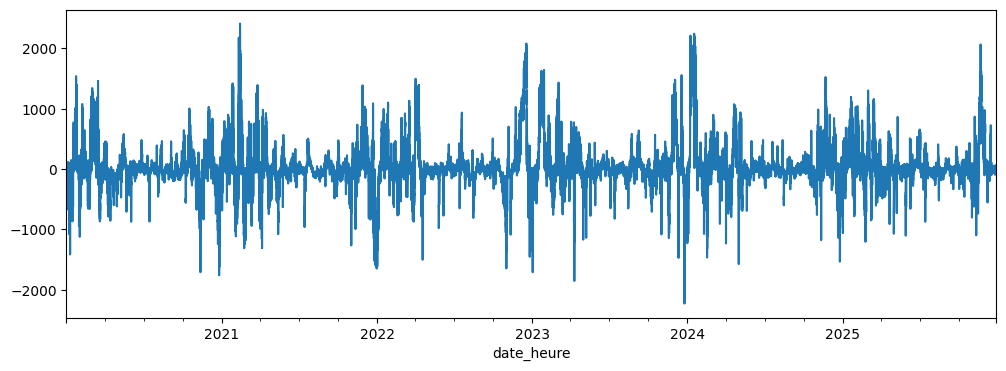

In [40]:
residuals_stationary = residuals - res_monthly.trend
residuals_stationary.plot(figsize=(12,4));

On va vérifier la stationnarité de la composante résiduelle avec un test ADF comme précédemment :

In [41]:
adf_table(residuals_stationary)

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-12.519593,-1.941005,Stationnaire
1,DGP2,-12.612745,-2.861595,Stationnaire
2,DGP3,-12.628512,-3.410574,Stationnaire


La composante résiduelle est très clairement stationnaire, on va pouvoir passer à la modélisation par un ARMA.

# 9 - Modèle ARMA sur les résidus obtenus

Un modèle ARMA est défini par 2 ordres : 
- **p** l'ordre de l'AR qui spécifie le nombre de termes autorégressifs à inclure dans le modèle. Il indique combien de valeurs passées sont utilisées pour prédire la valeur actuelle.
- **q** l'ordre du MA qui spécifie le nombre de termes de la moyenne mobile à inclure dans le modèle. Il indique combien de résidus passés sont utilisés pour prédire l'observation actuelle.

On va devoir déterminer ces ordres. Pour cela on dispose de plusieurs méthodes :
- visuellement en regardant l'ACF et le PACF
- en calculant les critères d'information AIC et BIC

On va ensuite confirmer la validité des paramètres choisis en vérifiant la blancheur des résidus du modèle ainsi estimé.

## 9.1 - Détermination des paramètres

### 9.1.1 - ACF et PACF

L'**ACF** (Autocorrelation Function) mesure la corrélation entre les valeurs d’une série temporelle et leurs valeurs décalées dans le temps appelées lags. La **PACF** (Partial Autocorrelation Function) mesure la corrélation entre une valeur et son lag, en éliminant l’influence des lags intermédiaires.

On utilise l'ACF et la PACF pour identifier si la série temporelle correspond plutôt à un modèle AR, MA ou ARMA et pour identifier les ordres p et q associés :

- modèle AR(p) : l'ACF décroît progressivement et la PACF chute brusquement après le lag p
- modèle MA(q) : la PACF décroît progressivement et l'ACF chute brusquement après le lag q
- modèle ARMA(p,q) : l'ACF et la PACF présente une décroissance plus complexe sans chute brutale

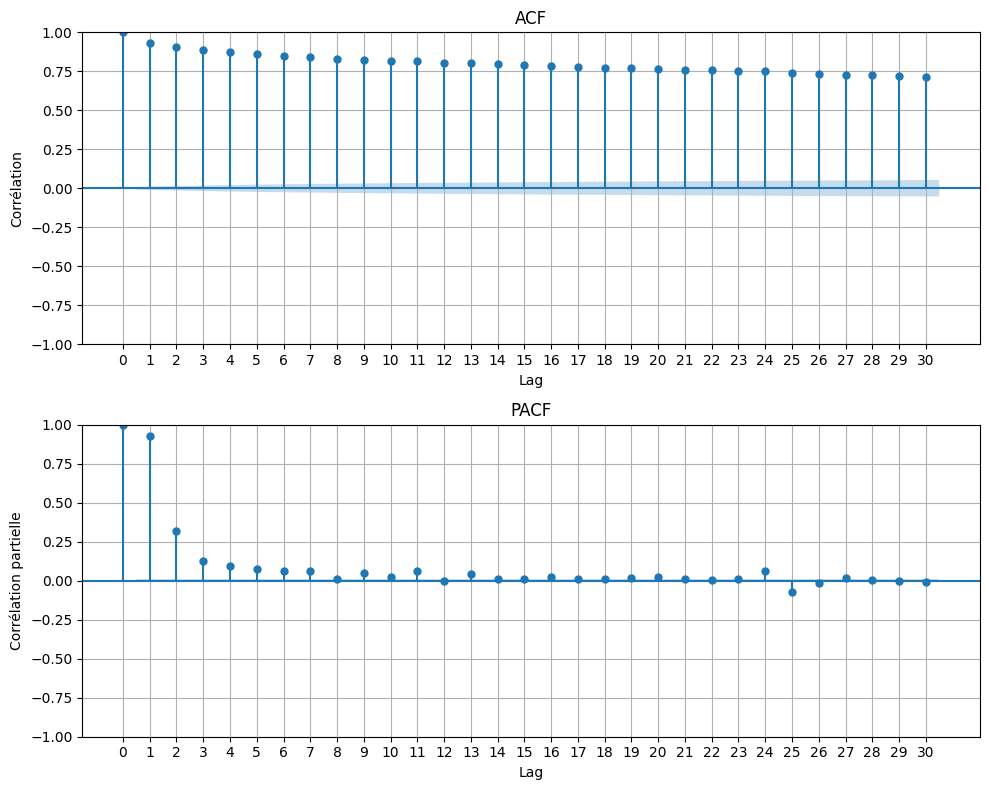

In [42]:
#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#ACF
plot_acf(residuals_stationary, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)
ax1.set_xticks(np.arange(0, 31, 1))

#PACF
plot_pacf(residuals_stationary, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)
ax2.set_xticks(np.arange(0, 31, 1))

#afficher
plt.tight_layout()
plt.show()

**Interprétation** :
- pas de coupure nette de l'ACF, donc il ne semble pas y avoir de partie MA $\implies$ q=0
- coupure nette de la PACF après le lag 2, semble suggérer un AR pur de lag 2 $\implies$ p=2
  
L'analyse de l'ACF et de la PACF semblerait nous suggérer d'utiliser un AR(2). On va estimer ce modèle et tester la blancheur des résidus obtenus par un test de Ljung-Box. Si ceux-ci ne sont pas blancs c'est que le modèle n'a pas capturé toute la structure du signal et n'est donc pas adapté à la série.

In [73]:
#ne pas afficher les warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [72]:
#AR2
ar2_model = ARIMA(residuals_stationary, order=(2,0,0))
ar2_fit = ar2_model.fit()

In [44]:
ar2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                52535
Model:                 ARIMA(2, 0, 0)   Log Likelihood             -324543.603
Date:                Mon, 29 Dec 2025   AIC                         649095.206
Time:                        21:05:02   BIC                         649130.683
Sample:                    01-01-2020   HQIC                        649106.293
                         - 12-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7120     10.851      3.291      0.001      14.444      56.980
ar.L1          0.6327      0.001    474.724      0.000       0.630       0.635
ar.L2          0.3201      0.001    242.545      0.000       0.317       0.323
sigma2      1.359e+04     24.297    559.528      0.000    1.35e+04    1.36e+04
===================================================================================
Ljung-Box (L1) (Q):                  90.62   Jarque-Bera (JB):           1333543.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Pb** : la p-value de la statistique de Ljung-Box est < 0.5 donc les résidus ne sont pas blancs, le modèle est abandonné. Cela est sans doute du au grand nombre d'observations ce qui peut modifier les seuils de significativité standards et rendre l'ACF et la PACF plus difficile à interpréter visuellement.

### 9.1.2 - Critères d'information

On compare différents modèles ARMA et on calcule le BIC pour chaque combinaison de p et q. On retient le modèle qui minimise le BIC.

In [46]:
model = pm.auto_arima(
    residuals_stationary,
    start_p=0, max_p=5,  #on teste les combinaisons de p et q entre 0 et 5
    start_q=0, max_q=5,
    d=0,                 #la série est déjà stationnaire
    seasonal=False,
    stepwise=True,
    information_criterion='bic',
    suppress_warnings=True)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                52535
Model:               SARIMAX(4, 0, 5)   Log Likelihood             -323214.210
Date:                Mon, 29 Dec 2025   AIC                         646448.420
Time:                        21:29:25   BIC                         646537.113
Sample:                    01-01-2020   HQIC                        646476.139
                         - 12-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0520      0.014     -3.721      0.000      -0.079      -0.025
ar.L2          1.5601      0.010    157.608      0.000       1.541       1.580
ar.L3          0.1739      0.013     13.149      0.0

**Interprétation** : la détermination du modèle par le BIC nous renvoie un ARMA(4,5). La p-value associée au test de Ljung-Box de blancheur des résidus est de 0.74 > 0.5 donc les résidus sont bien blancs c'est-à-dire qu'il ne reste pas de structure dans les données qui ne soit pas décrite par le modèle.

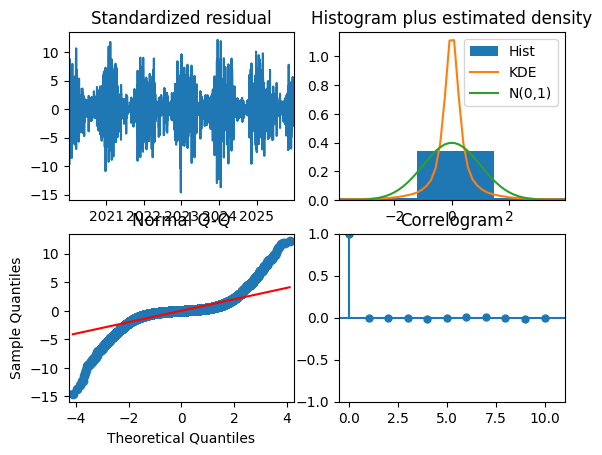

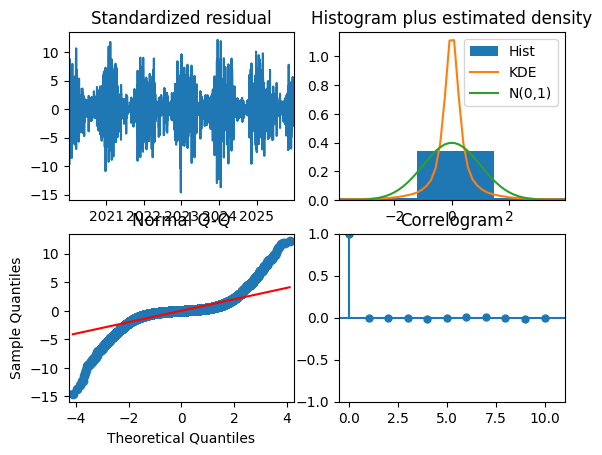

In [47]:
model.plot_diagnostics()

## 9.2 - Estimation du modèle

On va donc choisir un ARMA(4,2) pour modéliser nos données **dé-saisonnalisées** et **dé-trendées**. Il faut bien faire attention au fait que l'ARMA ne modélise ici que la composante résiduelle de la série temporelle initiale puisque l'on a désaisonnalisé la série et qu'on en a retiré la tendance.

On rappelle que pour $X_t$ la série des consommations de la métropole parisienne on a

$$X_t = T_t + S_t + \epsilon _t$$

avec $\epsilon _t \sim ARMA(4,2)$ que l'on a appelé `residual_stationnary`

L'ARMA(4,2) prédit donc $\hat{\epsilon_t}$ et non $X_t$ directement. Une fois $\hat{\epsilon_t}$ obtenu, il faut y rajouter la saisonnalité déterminée précedemment ainsi que la tendance.



L'objectif va être d'entrainer le modèle sur une partie des données (ensemble de **train**) puis de prédire l'autre partie des données (ensemble de **test**). Une fois la composante résiduelle prédite on lui ajoute les saisonnalités et la trend pour obtenir la vraie prédiction pour notre série. Finalement on évalue la qualité de la prédiction obtenue via différentes métriques.

On définit l'ensemble de test comme 20% des données dont on dispose.

In [59]:
#séparation train-test

n = len(residuals_stationary)
split_idx = int(n * 0.8)

train_resid = residuals_stationary.iloc[:split_idx]
test_resid  = residuals_stationary.iloc[split_idx:]
test_data = df_red['conso_final'].iloc[split_idx:]

In [71]:
#entrainer le modèle

arma_model = ARIMA(train_resid, order=(4, 0, 5), trend='n')
arma_fit = arma_model.fit()

In [62]:
arma_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                42028
Model:                 ARIMA(4, 0, 5)   Log Likelihood             -258936.604
Date:                Mon, 29 Dec 2025   AIC                         517893.208
Time:                        21:37:21   BIC                         517979.669
Sample:                    01-01-2020   HQIC                        517920.512
                         - 10-17-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5632      0.032     17.755      0.000       0.501       0.625
ar.L2          0.3189      0.044      7.182      0.000       0.232       0.406
ar.L3          0.7277      0.040     18.159      0.000       0.649       0.806
ar.L4         -0.6151      0.020    -30.395      0.000      -0.655      -0.575
ma.L1         -0.0103      0.032     -0.326      0.744      -0.072       0.052
ma.L2         -0.1127      0.033     -3.386      0.001      -0.178      -0.047
ma.L3         -0.7548      0.027    -28.067      0.000      -0.808      -0.702
ma.L4          0.2042      0.008     25.365      0.000       0.188       0.220
ma.L5         -0.0381      0.003    -11.226      0.000      -0.045      -0.031
sigma2       1.32e+04     27.352    482.628      0.000    1.31e+04    1.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1040922.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
#prédire la composante résiduelle de l'ensemble de test

epsilon_hat = arma_fit.forecast(steps=len(test_resid))

In [64]:
#récupérer la saisonnalité
season_test = (res_daily.seasonal.loc[test_resid.index] + res_weekly.seasonal.loc[test_resid.index]
    + res_monthly.seasonal.loc[test_resid.index])

#récupérer la trend
trend_test = res_monthly.trend.loc[test_resid.index]

#prédiction finale
test_pred = epsilon_hat + season_test + trend_test

## 9.3 - Evaluation de la qualité de la prédiction

On va évaluer la qualité de la prédiction tout d'abord visuellement puis à l'aide de métriques telles que la MAE, la RMSE ou la statistique de Theil.

### 9.3.1 - Evaluation graphique

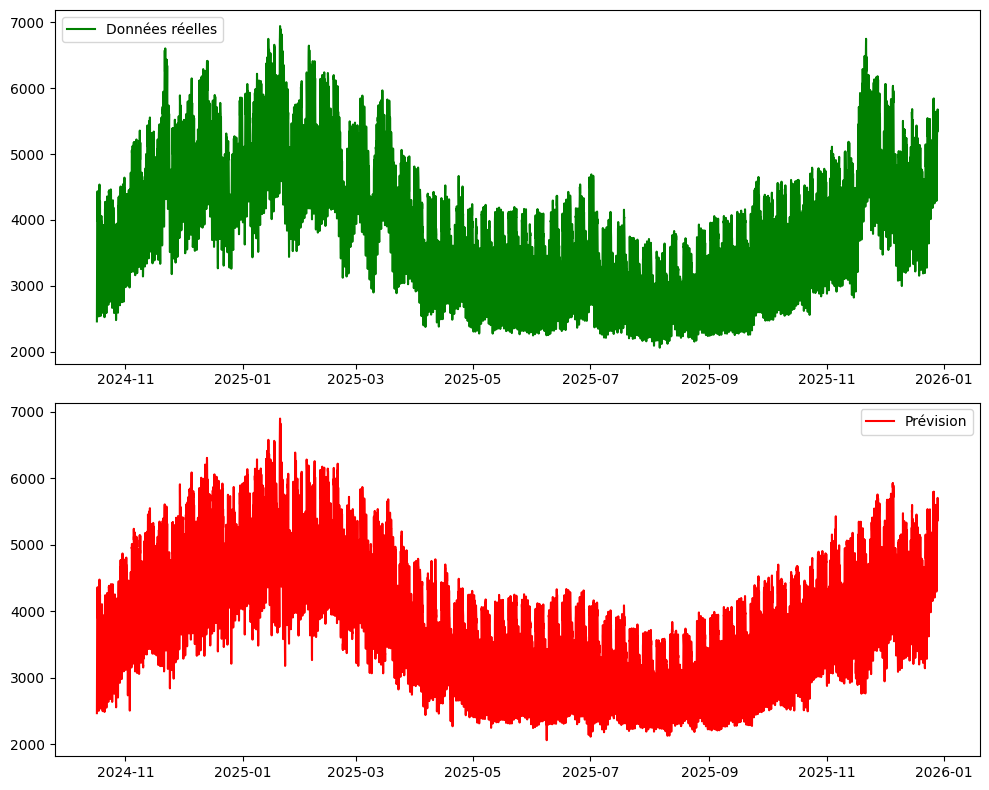

In [65]:
#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#données réelles
ax1.plot(test_data, label="Données réelles", color="green")
ax1.legend()

#prédictions
ax2.plot(test_pred, label='Prévision', color="red")
ax2.legend()

#afficher
plt.tight_layout()
plt.show()

**Interprétation** : On remarque tout d'abord que le motif global est plutôt bien prédit. Mais certains pics et variations spécifiques ne sont pas prédits. Par exemple, l'augmentation de la consommation très marquée fin novembre n'est pas prédite. Ici croiser avec les données météo pourrait avoir un vrai avantage : cette hausse est peut-être due à une soudaine vague de froid, qui n'a pas nécessairement d'antécédent historique à cette date.

On va analyser la qualité de la prédiction plus rigoureusement en calculant différentes métriques.

### 9.3.2 - MAE et RMSE

Soit 1 la première prévision effectuée et $N_p$ la dernière. On note ${}_{i-1} \hat{X}_i$ la valeur prédite pour $X$ à la date $i$ effectuée à la date $i-1$. 

On peut évaluer la qualité de la prédiction par différentes métriques :
- <u>Mean Absolute Error</u> : mesure l'erreur moyenne absolue, robuste aux valeurs extrêmes
$$MAE(h) = \frac{1}{N_p} \sum_{i=1}^{N_p} |X_{i+h} - {}_{i} \hat{X}_{i+h}|$$
- <u>Root Mean Squared Error</u> : accorde plus de poids aux grosses erreurs
$$RMSE(h) = \sqrt {\frac{1}{N_p} \sum_{i=1}^{N_p} (X_{i+h} - {}_{i} \hat{X}_{i+h})^2}$$

Ces deux métriques évaluent une prévision à l'horizon h et sont à minimiser.

In [66]:
rmse = np.sqrt(mean_squared_error(test_data, test_pred))
mae = mean_absolute_error(test_data, test_pred)

print("MAE :", mae)
print("RMSE :", rmse)

MAE : 151.8429079266613
RMSE : 277.0448045733846


**Interprétation** : ces valeurs ne s'interprètent pas directement, elles sont à comparer avec celles obtenues par d'autres modèles pour déterminer quel modèle prédit le mieux. On va s'en servir pour comparer les prévisions effectuées uniquement à partir des données historiques de celles établies en ajoutant les données météorologiques.

On peut néanmoins les utiliser en les exprimant en pourcentage de la variation des données afin de comparer la précision du modèle à l’amplitude des données. On obtient alors l'erreur relative en pourcentage donnée par le formule suivante (avec MAE ou RMSE) :

$$ ER = \frac{RMSE}{max(X_t) - min(X_t)} \times 100 $$

In [67]:
variation_max = df_red['conso_final'].max() - df_red['conso_final'].min()

rmse_pct = rmse / variation_max * 100
mae_pct = mae / variation_max * 100

print("Erreur relative en % (RMSE) :", rmse_pct)
print("Erreur relative en % (MAE) :", mae_pct)

Erreur relative en % (RMSE) : 4.798974615856308
Erreur relative en % (MAE) : 2.6302253235174313


Ces résultats s'interprètent comme suit :
$$
\begin{array}{|c|l|}
\hline
\textbf{\% de la variation maximale} & \textbf{Interprétation} \\
\hline
<5\% & \text{Très bonne précision, modèle excellent} \\
\hline
5-10\% & \text{Bonne précision, erreurs relativement faibles} \\
\hline
10-20\% & \text{Acceptable pour des séries très bruyantes ou fortement variables} \\
\hline
>20\% & \text{Peut être trop élevé, le modèle peut manquer des pics importants} \\
\hline
\end{array}
$$


**Interprétation**  :
- MAE faible ($\approx$ 2.6%) $\implies$ en moyenne la prévision se trompe peu, le modèle prédit très bien
- RMSE légèrement plus élevé ($\approx$ 4.8 %) $\implies$ les erreurs sont un peu plus grandes sur certains pics (comme on a pu le constater visuellement) mais cela reste correct.

### 9.3.3 - Statistique de Theil

La statistique de Theil est valable à l'horizon 1. Elle est définit par la formule suivante : 
$$ U = \sqrt \frac{ \sum_{i=1}^{N_p} (X_i - {}_{i-1} \hat{X}_i)^2 } { \sum_{i=1}^{N_p} (X_i - X_{i-1})^2 } $$
On a :
- U $\approx$ 0 $\implies$ bonne prévision
- U = 1 $\implies$ modèle aussi performant que le modèle naïf (on prédit $X_{t+1}$ par $X_t$)
- U > 1 $\implies$ modèle pire que le modèle naïf

In [68]:
U = np.sqrt(np.mean((test_data - test_pred)**2)) / \
    (np.sqrt(np.mean(test_data**2)) + np.sqrt(np.mean(test_pred**2)))

print("Statistique de Theil :", U)

Statistique de Theil : 0.0335439719301629


**Interprétation** : statistique très proche de 0, indique que le modèle prédit très bien

# 10 - Conclusion

Les prédictions futures à partir des données historiques sont déjà très bonnes et plus que correctes. Nous allons voir par la suite l'apport que les données météorologiques peuvent avoir sur la qualité de la prédiction.